In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from cifar_data import CIFAR10

train_data = CIFAR10(is_train=True)
test_data  = CIFAR10(is_train=False, shuffle=False)

print(train_data.class_names)
print(train_data.X.shape, train_data.y.shape)
print(test_data.X.shape, test_data.y.shape)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


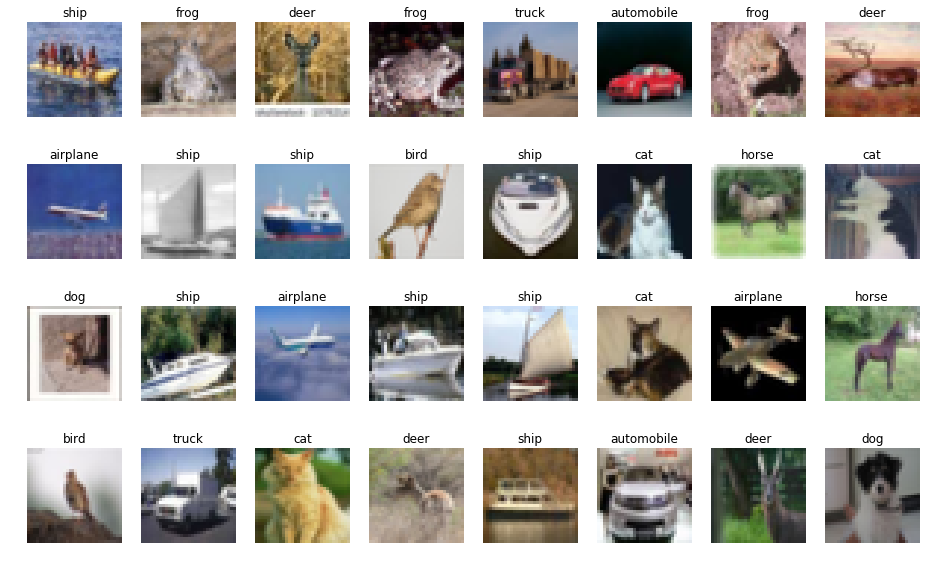

In [2]:
# 샘플 출력 및 시각화
%matplotlib inline
import matplotlib.pyplot as plt

plot_idx = np.random.randint(0, len(train_data.X), 32)

plot_images = train_data.X[plot_idx]
plot_labels = train_data.y[plot_idx]

fig = plt.figure(figsize=(16, 10))
for i, (img, label) in enumerate(zip(plot_images, plot_labels)):
    a = fig.add_subplot(4, 8, i+1)
    a.axis("off")
    a.set_title(train_data.class_names[label])
    plt.imshow(img)

In [3]:
def batch_norm_params(is_training):
    return {
        "decay": 0.9,
        "updates_collections": None,
        "is_training": is_training
    }

def arg_scope(is_training):
    with slim.arg_scope([slim.conv2d],
        weights_initializer=slim.variance_scaling_initializer(),
        activation_fn=tf.nn.relu,
        normalizer_fn=slim.batch_norm,
        normalizer_params=batch_norm_params(is_training),
        stride=1, padding="SAME"):
        with slim.arg_scope([slim.batch_norm],
                            **batch_norm_params(is_training)) as arg_scp:
            return arg_scp
        
def cifar_net(inputs, scope="cifarnet"):
    net = inputs
    
    with tf.variable_scope(scope) as scp:
        end_pts_collection = scp.name+"_end_pts" # cifarnet_end_pts
        with slim.arg_scope([slim.conv2d, slim.fully_connected],
                            outputs_collections=end_pts_collection):
            net = slim.conv2d(net, 64, [3, 3], scope="conv1") # [32, 32, 64]
            net = slim.max_pool2d(net, [2, 2], scope="pool1") # [16, 16, 64]
            
            net = slim.conv2d(net, 128, [3, 3], scope="conv2") # [16, 16, 128]
            net = slim.max_pool2d(net, [2, 2], scope="pool2")  # [8, 8, 128]
            
            net = slim.conv2d(net, 128, [3, 3], scope="conv3") # [8, 8, 128]
            net = slim.max_pool2d(net, [2, 2], scope="pool3")  # [4, 4, 128]
            
            net = slim.conv2d(net, 256, [3, 3], scope="conv4") # [4, 4, 256]
                        
            # FC 레이어를 conv2d 레이어로 구현 가능
            net = slim.conv2d(net, 512, [4, 4], 
                              padding="VALID", scope="fc1")  # [1, 1, 512]
            net = slim.conv2d(net, 512, [1, 1], scope="fc2") # [1, 1, 512]
            net = slim.conv2d(net, 10, [1, 1],               # [1, 1, 10]
                              activation_fn=None,
                              normalizer_fn=None,
                              normalizer_params=None,
                              scope="logit")
            
            net = tf.squeeze(net, [1, 2], name="logit/squeeze")

            end_pts = slim.utils.convert_collection_to_dict(end_pts_collection)  
            end_pts["prediction"] = slim.softmax(net, scope="prediction")
    return net, end_pts

In [4]:
learning_rate = 0.01

inputs = tf.placeholder(tf.float32, [None, 32, 32, 3])
labels = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool) # 배치 정규화 및 dropout 사용시 필요

with slim.arg_scope(arg_scope(is_training)) as scp:
    logit, end_pts = cifar_net(inputs)
    
for k, v in end_pts.items():
    print(k, v.get_shape())
print(logit.get_shape())

cifarnet/conv1 (?, 32, 32, 64)
cifarnet/conv2 (?, 16, 16, 128)
cifarnet/conv3 (?, 8, 8, 128)
cifarnet/conv4 (?, 4, 4, 256)
cifarnet/fc1 (?, 1, 1, 512)
cifarnet/fc2 (?, 1, 1, 512)
cifarnet/logit (?, 1, 1, 10)
prediction (?, 10)
(?, 10)


In [5]:
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logit))
opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_op)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

for step in range(10000):
    batch_X, batch_y = train_data.next_batch(128)
    _, loss = sess.run([opt, loss_op], feed_dict={inputs: batch_X, labels:batch_y, is_training: True})
    
    if (step+1) % 500 == 0:
        print(step+1, loss)

500 0.982582
1000 0.887226
1500 0.733043
2000 0.487266
2500 0.622251
3000 0.521188
3500 0.350681
4000 0.285947
4500 0.203495
5000 0.182244
5500 0.0868703
6000 0.0736822
6500 0.0990276
7000 0.0655807
7500 0.0351879
8000 0.030501
8500 0.0386983
9000 0.0321851
9500 0.0272838
10000 0.020914


In [6]:
# 테스트 시 사용하는 연산 그래프 정의
pred_op = end_pts["prediction"]
correct_op = tf.equal(labels, tf.argmax(pred_op, 1))
num_correct_op = tf.reduce_sum(tf.cast(correct_op, tf.float32))

# 배치 단위로 테스트 (매우 매우 구린 코드지만..)
num_correct = 0
while True:
    batch_X, batch_y = test_data.next_batch(128)
    num_correct += sess.run(num_correct_op, 
        feed_dict={inputs:batch_X, labels:batch_y, is_training: False})
    
    if test_data.epoch_done:
        break

acc_test = num_correct / len(test_data.X)
print("step", step+1, "test_accuracy:", acc_test)

step 10000 test_accuracy: 0.7076
